In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage.draw import line
import random
import json
import time

%matplotlib inline

In [2]:
# load the fixed dem
savefile = "dems/brooklyn10mfixed.npy"
dem2 = np.load(savefile)
print(dem2.shape)

(1403, 1073)


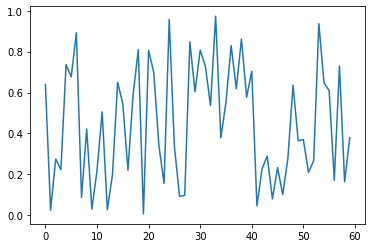

In [3]:
################################
# THRESHOLD TESTING
################################

window_size = 90
bands = 60
step_size = 3
#similarity_threshold = 0
seed = 42
assert bands <= window_size


# generate the thresholds
random.seed(seed)
thresholds = [random.random() for i in range(bands)] # instead of range(window_size)
#thresholds = np.asarray(thresholds)
#thresholds *= 0.8 # to leave wiggle room at the top since we're doing "> threshold"
random.seed(seed)
indices = random.sample(range(window_size), bands)

plt.plot(thresholds)
plt.show()

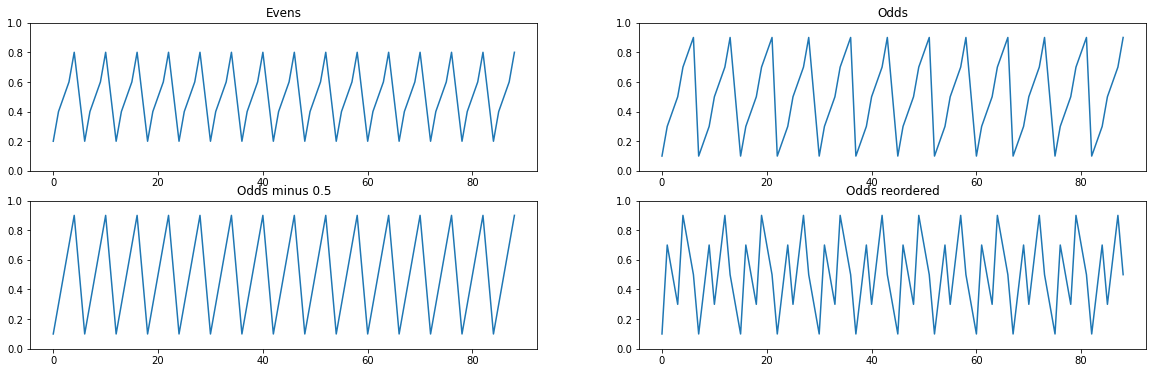

In [4]:
# pick more intelligent thresholds?
# NOTE: don't rely on random indices either!

fig = plt.figure(figsize=(20,6))
#x = range(0,90,step_size)
x = [int(x) for x in np.linspace(0, window_size, bands, endpoint=False)]

evens = [0.2, 0.4, 0.6, 0.8]*(bands//4)
evens += evens[:bands%4]
#henc = np.where(h90norm[indices] > evens, 1, 0)
#print(henc)
plt.subplot(221)
plt.plot(x,evens)
plt.title("Evens")
plt.ylim(0,1)

odds = [0.1, 0.3, 0.5, 0.7, 0.9]*(bands//5)
odds += odds[:bands%5]
plt.subplot(222)
plt.plot(x,odds)
plt.title("Odds")
plt.ylim(0,1)

# cut out 0.5, lose a little of the middle but capture the extremes
t3 = [0.1, 0.3, 0.7, 0.9]*(bands//4)
t3 += t3[:bands%4]
plt.subplot(223)
plt.plot(x,t3)
plt.title("Odds minus 0.5")
plt.ylim(0,1)

# reorganize odds
odds2 = [0.1, 0.7, 0.3, 0.9, 0.5]*(bands//5)
odds2 += odds2[:bands%5]
plt.subplot(224)
plt.plot(x,odds2)
plt.title("Odds reordered")
plt.ylim(0,1)
plt.show()

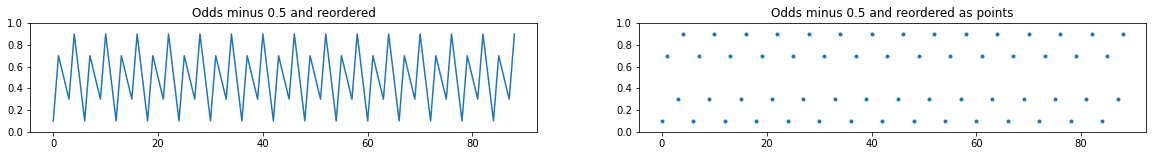

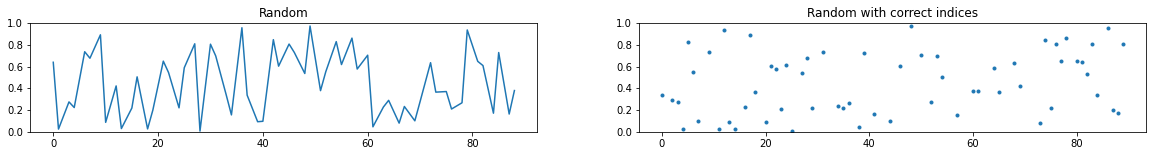

In [5]:
# best of both worlds: focus on extremes and reorder
odds3 = [0.1, 0.7, 0.3, 0.9]*(bands//4)
odds3 += odds3[:bands%4]
fig = plt.figure(figsize=(20,2))
plt.subplot(121)
plt.plot(x,odds3)
plt.title("Odds minus 0.5 and reordered")
plt.ylim(0,1)

# as points
odds3 = [0.1, 0.7, 0.3, 0.9]*(bands//4)
odds3 += odds3[:bands%4]
plt.subplot(122)
plt.plot(x,odds3,".")
plt.title("Odds minus 0.5 and reordered as points")
plt.ylim(0,1)
plt.show()

# compared to original random thresholds
fig = plt.figure(figsize=(20,2))
plt.subplot(121)
plt.plot(x,thresholds)
plt.title("Random")
plt.ylim(0,1)

# with correct indices
plt.subplot(122)
plt.plot(indices,thresholds,".")
plt.title("Random with correct indices")
plt.ylim(0,1)
plt.show()

In [6]:
####################################
# CREATE THRESHOLDS/INDICES
####################################
# NOTE: if we lower bands, we have to keep similarity_threshold low too to filter out too many collisions

#window_size = 90
#bands = 45
#step_size = 2
#similarity_threshold = 0
#seed = 42
#assert bands <= window_size

have_template = False # so we create the encoded horizon template later
all_similar_matches = []

# generate the thresholds and random indices once outside the loop
random.seed(seed)
thresholds = [random.random() for i in range(bands)] # instead of range(window_size)
#thresholds = np.asarray(thresholds)
#thresholds *= 0.8 # to leave wiggle room at the top since we're doing "> threshold"
random.seed(seed)
indices = random.sample(range(window_size), bands)

# vs just use a pre-generated set of thresholds
# thresholds = odds3
# indices = [x for x in range(0,90,step_size)]
print(thresholds)
print(indices)

####################################
# select random points, collect all horizons, look for collisions
num_points = 1000
point_seed = 123
random.seed(point_seed)
####################################
start_time = time.time()
normalized_encoded_horizon_dict = {}
nonnorm_nonencoded_horizon_dict = {}

# pick num_points random points
start_points = []
for i in range(num_points):
    row = random.randint(100,1300)
    col = random.randint(100,1000)
    new_point = [row,col]
    while new_point in start_points:
        row = random.randint(100,1300)
        col = random.randint(100,1000)
        new_point = [row,col]
    start_points.append(new_point)

for ii,start in enumerate(start_points):
    ######################################
    # GET HORIZON IN ALL 360 DIRECTIONS
    ######################################
    #start = [600, 600]
    print(ii, start)
    horizon_locations = []
    horizon_elevations = []
    horizon_thetas = []
    angle_step_size = 1

    # get horizon at every X degrees around our centerpoint
    for direction in range(0, int(360/angle_step_size), 1): # use division instead of 3rd range() param for step
                                                            # so we can use fraction step sizes like 0.5 degrees
        direction *= angle_step_size
#         if direction%45==0:
#             print(direction)
        radians = np.deg2rad(direction)

        # adjust opp and adj depending on quadrant of the angle
        if direction >= 0 and direction < 90:
            adj = dem2.shape[1]-start[1]
            opp = np.tan(radians)*adj
        elif direction > 90 and direction < 180:
            adj = -start[1]
            opp = np.tan(radians)*adj
        elif direction >= 180 and direction < 270:
            adj = -start[1]
            opp = np.tan(radians)*adj
        elif direction > 270: # and direction < 360:
            adj = dem2.shape[1]-start[1]
            opp = np.tan(radians)*adj
        elif direction == 90: # tan(90 degrees) is infinity
            adj = 0
            opp = start[0]
        elif direction == 270: # tan(270 degrees) is infinity
            adj = 0
            opp = start[0]-dem2.shape[0]

        #https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array
        #https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
        # can switch below to skimage.draw.line() for fast rows/cols. can use line_aa() for anti-aliasing to make less jagged.

        # make a line with "num" points...
        x0, y0 = start[1], start[0] # these are in pixel coordinates
        x1, y1 = start[1]+adj, start[0]-opp # NOTE: y values are reversed because rows start at the top
        num = int(np.hypot(x1-x0, y1-y0)) # approx num of pixels from point to edge of image
        x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

        # check for out of bounds before mapping
        indx = 0
        while indx < len(x):
            if x[indx] < 0 or x[indx] >= dem2.shape[1]:
                break
            else:
                indx += 1
        indy = 0
        while indy < len(y):
            if y[indy] < 0 or y[indy] >= dem2.shape[0]:
                break
            else:
                indy += 1
        # always take the smaller to stay inside the dem array
        if indx <= indy:
            x = x[:indx]
            y = y[:indx]
        else:
            x = x[:indy]
            y = y[:indy]

        # now map!
        zi = scipy.ndimage.map_coordinates(dem2, np.vstack((y,x)))

        # initialize values before loop
        start_elev = dem2[start[0], start[1]] + 2 # start 2m higher to prevent small changes from nearby pixels having
                                                  # the highest thetas, plus many images are taken at eye level
        maxtheta = -np.pi/4 # lowest possible = 90 degrees down
        highest_location = start.copy()
        highest_elevation = -999999.

        # go through each value along the hypotenuse zi
        for dist_along_hypot,elev in enumerate(zi):
            if dist_along_hypot > 0: # skip the first value bc that's where we're starting from

                # adjacent length is 10m per pixel, which is 10x height, so multiply col by 10 to match height ratio
                # NOTE: adjacent pixel gsd is arbitrary so could skip multiplying by 10. yes, all angles will be off,
                #       but they will be off proportionately! and all we need is where the biggest angle is anyway.
                #       we don't need that biggest angle to be accurate (at least for now...)
                # NOTE: keeping the multiplication by 10 though because we need an accurate adj value for the opp formula!
                adj = dist_along_hypot*10

                # subtract start_elev to normalize all other elevations
                # also, subtract 8 inches per mile according to https://www.omnicalculator.com/physics/earth-curvature
                # 8 inches = 0.2032 meters, 1 mile = 1609.34 meters
                opp = elev - start_elev - (adj*0.2032/1609.34)

                # find theta with arctan(opposite/adjacent)
                newtheta = np.arctan(opp/adj)

                # biggest angle is the horizon
                if newtheta > maxtheta:
                    maxtheta = newtheta
                    # calc row and col position given angle and hypotenuse. SOHCAHTOA
                    rows_above_start = np.sin(radians)*dist_along_hypot
                    cols_right_of_start = np.cos(radians)*dist_along_hypot
                    highest_location = [start[0]-rows_above_start, start[1]+cols_right_of_start]
                    highest_elevation = elev

        # store horizon values
        horizon_locations.append(highest_location)
        horizon_elevations.append(highest_elevation)
        horizon_thetas.append(maxtheta)
    
#     ###############################
#     # GRAPH FULL 360 HORIZON
#     ###############################
#     rows, cols = zip(*horizon_locations)

#     fig = plt.figure(figsize=(15, 15))

#     ax = fig.add_subplot(111)
#     ax.set_title('Horizon Overlay')
#     plt.imshow(dem2)
#     for i in range(len(cols)):
#         rows2 = [start[0], rows[i]]
#         cols2 = [start[1], cols[i]]
#         plt.plot(cols2, rows2, 'r-')
#         #plt.plot(start[1], start[0], 'ro') # NOTE: expects x,y not row,col so reverse them
#         #plt.plot(cols,rows, 'rx-') # NOTE: expects x,y not row,col so reverse them

#     # start point in green
#     plt.plot([start[1]], [start[0]], 'go', markersize=8)

#     ax.set_aspect('equal')
#     cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
#     cax.get_xaxis().set_visible(False)
#     cax.get_yaxis().set_visible(False)
#     cax.patch.set_alpha(0)
#     cax.set_frame_on(False)
#     plt.colorbar(orientation='vertical', ax=ax)
#     plt.show()
    
    # so use horizon_thetas instead and use opp = tan()*adj with a set adjacent length
    adj = 1 # this value doesn't matter if we are normalizing both our template and each subsection in the sliding window
    h2 = [adj*np.tan(x) for x in horizon_thetas] # can remove multiplying by adj altogether bc of above comment
    h2.reverse()

#     fig2, ax2 = plt.subplots(figsize=(20,5))
#     plt.subplot(212)
#     plt.plot(h2)
#     #plt.ylim(0,100)
#     for key,value in cardinals.items():
#         plt.vlines(x=key, ymin=min(h2), ymax=0.8*max(h2), colors='purple', label=value, linestyle='dashed')
#         plt.annotate(text=value, xy=(key, 0.9*max(h2)), xytext=(key, 0.9*max(h2)), ha="center")
#     plt.title("Horizon")
#     plt.show()
    
    ###########################################
    # CREATE TEMPLATE (if we haven't already)
    ###########################################
    # create template once
    if not have_template:
        # get first 90 degree section for template
        h90 = h2[0:90]
        # normalize it
        h90norm = (h90 - np.min(h90)) / (np.max(h90) - np.min(h90))
        henc2 = np.where(h90norm[indices] > thresholds, 1, 0)
        have_template = True

    #########################################
    # COMPARE TEMPLATE TO HORIZON
    #########################################
    # test encoding in all 360 degrees
    similar_horizon_starting_points = []
    diffs = []
    for start_ind in range(360):
        # get values from horizon
        if start_ind+window_size > 360:
            h90 = h2[start_ind:]
            h90 += h2[:window_size-len(h90)]
        else:
            h90 = h2[start_ind:start_ind+window_size]

        # normalize it
        h90norm = (h90 - np.min(h90)) / (np.max(h90) - np.min(h90))
        h90norm = np.asarray(h90norm)

        # apply thresholds
        henc3 = np.where(h90norm[indices] > thresholds, 1, 0)
        
        ###############################
        # ADD TO DICT FOR JSON LATER
        ###############################
        key = ""
        for zero_or_one in henc3:
            key += str(zero_or_one)
        #print("key", key)
        if not normalized_encoded_horizon_dict.get(key, False):
            normalized_encoded_horizon_dict[key] = []
        normalized_encoded_horizon_dict[key].append([start, start_ind])

    # add nonnorm nonencoded original horizon to dict so we can quickly look up horizons
    #    for each start point
    startstr = str(start)
    nonnorm_nonencoded_horizon_dict[startstr] = h2

#         # if difference is small enough between horizons, keep it
#         thediff = sum(np.abs(henc3-henc2))
#         if thediff <= similarity_threshold:
#             similar_horizon_starting_points.append(start_ind)
#             diffs.append(thediff)
#             all_similar_matches.append([start, start_ind])

#     print("similar_horizon_starting_points", similar_horizon_starting_points)
#     print("diffs", diffs)
    
#     ################################
#     # SHOW SIMILAR HORIZONS
#     ################################
#     if len(similar_horizon_starting_points):
#         ncols = 4
#         extrarow = 1 if len(similar_horizon_starting_points)%ncols > 0 else 0
#         nrows = len(similar_horizon_starting_points)//ncols + extrarow

#         fig, ax = plt.subplots(figsize=(20,2*nrows))

#         for i,start_ind in enumerate(similar_horizon_starting_points):
#             # get values from horizon
#             if start_ind+window_size > 360:
#                 h90 = h2[start_ind:]
#                 h90 += h2[:window_size-len(h90)]
#             else:
#                 h90 = h2[start_ind:start_ind+window_size]

#             # normalize it
#             h90norm = (h90 - np.min(h90)) / (np.max(h90) - np.min(h90))

#             # plot it
#             plt.subplot(nrows, ncols, i+1)
#             plt.title(str(start_ind))
#             plt.plot(h90norm)
#         plt.show()
#     else:
#         print("No similar horizons for", start)

print("Done!")
end_time = time.time()

[0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, 0.029797219438070344, 0.21863797480360336, 0.5053552881033624, 0.026535969683863625, 0.1988376506866485, 0.6498844377795232, 0.5449414806032167, 0.2204406220406967, 0.5892656838759087, 0.8094304566778266, 0.006498759678061017, 0.8058192518328079, 0.6981393949882269, 0.3402505165179919, 0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0.09274584338014791, 0.09671637683346401, 0.8474943663474598, 0.6037260313668911, 0.8071282732743802, 0.7297317866938179, 0.5362280914547007, 0.9731157639793706, 0.3785343772083535, 0.552040631273227, 0.8294046642529949, 0.6185197523642461, 0.8617069003107772, 0.577352145256762, 0.7045718362149235, 0.045824383655662215, 0.22789827565154686, 0.28938796360210717, 0.0797919769236275, 0.23279088636103018, 0.10100142940972912, 0.2779736031100921, 0.6356844442644002,

449 [961, 509]
450 [1123, 165]
451 [485, 287]
452 [814, 334]
453 [773, 814]
454 [949, 854]
455 [1100, 219]
456 [910, 175]
457 [835, 621]
458 [869, 204]
459 [501, 363]
460 [283, 809]
461 [347, 477]
462 [458, 294]
463 [268, 986]
464 [233, 532]
465 [1018, 847]
466 [994, 558]
467 [182, 524]
468 [205, 196]
469 [712, 619]
470 [904, 485]
471 [780, 476]
472 [815, 164]
473 [782, 720]
474 [479, 223]
475 [155, 555]
476 [902, 612]
477 [758, 133]
478 [519, 923]
479 [687, 423]
480 [687, 255]
481 [754, 719]
482 [1066, 469]
483 [563, 647]
484 [170, 730]
485 [1064, 958]
486 [418, 312]
487 [776, 346]
488 [1074, 671]
489 [553, 969]
490 [739, 895]
491 [433, 301]
492 [1049, 593]
493 [777, 587]
494 [1015, 574]
495 [652, 546]
496 [700, 181]
497 [906, 987]
498 [1054, 200]
499 [759, 491]
500 [1259, 677]
501 [1186, 232]
502 [577, 892]
503 [217, 264]
504 [952, 908]
505 [1142, 554]
506 [658, 721]
507 [581, 895]
508 [695, 279]
509 [1165, 343]
510 [954, 927]
511 [269, 697]
512 [889, 660]
513 [229, 477]
514 [1053, 8

986 [354, 281]
987 [1111, 465]
988 [395, 789]
989 [839, 821]
990 [240, 745]
991 [539, 464]
992 [258, 547]
993 [326, 782]
994 [984, 155]
995 [1000, 816]
996 [456, 627]
997 [589, 161]
998 [537, 635]
999 [427, 283]
Done!


In [7]:
total_time = end_time - start_time
print(round(total_time/60//60), "hours", round(total_time/60%60), "minutes")

6 hours 27 minutes


In [8]:
##################
# DUMP INTO JSONS
##################
filename = "dicts/normalized_encoded_horizon_dict_window"+str(window_size)+"_bands"+str(bands)+"_random_seed"+str(seed)+".json"
with open(filename, "w") as f:
    json.dump(normalized_encoded_horizon_dict, f)

# don't need to rewrite...
# filename = "dicts/nonnorm_nonencoded_horizon_dict_numpoints"+str(num_points)+"_pointseed"+str(point_seed)+".json"
# with open(filename, "w") as f:
#     json.dump(nonnorm_nonencoded_horizon_dict, f)

110000011111111001110011001110101010001001101011110100101011 [[[207, 374], 0], [[1226, 166], 176], [[568, 406], 163], [[517, 455], 329], [[517, 455], 330]]
[207, 374] [0.007200651372053019, 0.0068884122002936185, 0.006277294407492501, 0.006651629709925998, 0.006865123811669359, 0.005857895471426039, 0.005457012941593334, 0.006870076911238801, 0.005329141094280073, 0.0053073402323578775, 0.005142756273502514, 0.005474815729142902, 0.005653454716023316, 0.007324594222388345, 0.008535219750100152, 0.007337288891880662, 0.00789060709993272, 0.007755441478051285, 0.007285532858144148, 0.007283925034033391, 0.007107843843509733, 0.005570565884577234, 0.004666005024271834, 0.006982881782455871, 0.004988467650582739, 0.005710605919396865, 0.006204142547757354, 0.006338332047043694, 0.0061062339194480975, 0.0057555090112642844, 0.005828711386241018, 0.005571735351812395, 0.005623420263899338, 0.005924163346796353, 0.006319963388932384, 0.006001035362759172, 0.005882621557407158, 0.0061723744500

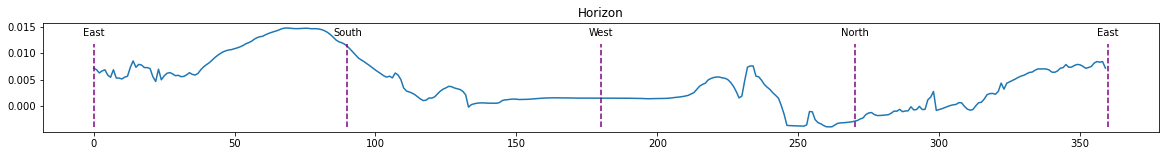

In [9]:
##################
# LOAD JSON
##################
filename = "dicts/normalized_encoded_horizon_dict_window"+str(window_size)+"_bands"+str(bands)+"_random_seed"+str(seed)+".json"
with open(filename) as f:
    normalized_encoded_horizon_dict = json.load(f)
    for k,v in normalized_encoded_horizon_dict.items():
        print(k,v)
        break

filename = "dicts/nonnorm_nonencoded_horizon_dict_numpoints"+str(num_points)+"_pointseed"+str(point_seed)+".json"
with open(filename) as f:
    nonnorm_nonencoded_horizon_dict = json.load(f)
    for p,h2 in nonnorm_nonencoded_horizon_dict.items():
        print(p,h2)
        break

fig = plt.figure(figsize=(20,2))
plt.plot(h2)
#plt.ylim(0,100)
cardinals = {0:"East", 90:"South", 180:"West", 270:"North", 360:"East"}
for key,value in cardinals.items():
    plt.vlines(x=key, ymin=min(h2), ymax=0.8*max(h2), colors='purple', label=value, linestyle='dashed')
    plt.annotate(text=value, xy=(key, 0.9*max(h2)), xytext=(key, 0.9*max(h2)), ha="center")
plt.title("Horizon")
plt.show()

(0.0, 1403.0)

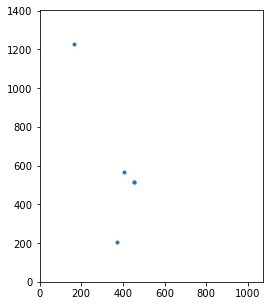

In [10]:
# plot points with similar horizons to find clusters
points = [p for p,d in v]
x = [x for y,x in points]
y = [y for y,x in points]
fig = plt.figure(figsize=(4,5))
plt.plot(x,y, ".")
plt.xlim(0,1073)
plt.ylim(0,1403)

In [11]:
print(len(normalized_encoded_horizon_dict.items()))
print(len(nonnorm_nonencoded_horizon_dict.items()))

206177
1000


110000011111111001110011001110101010001001101011110100101011 [[[207, 374], 0], [[1226, 166], 176], [[568, 406], 163], [[517, 455], 329], [[517, 455], 330]]
[[207, 374], 0]
[[1226, 166], 176]
[[568, 406], 163]
[[517, 455], 329]
[[517, 455], 330]


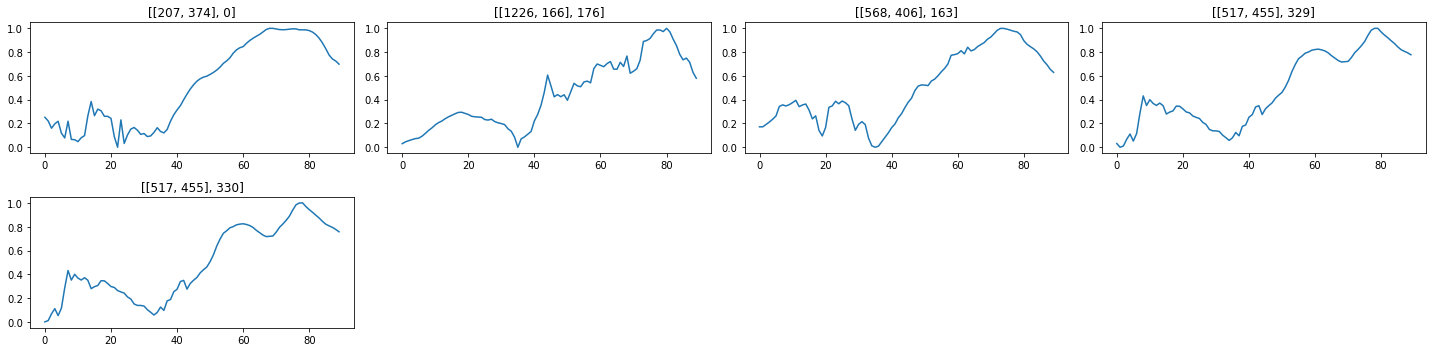

In [12]:
# examine all horizon collisions from the first item in normalized_encoded_horizon_dict
for horizon_encoding,similar_horizon_starting_points in normalized_encoded_horizon_dict.items():
    print(horizon_encoding,similar_horizon_starting_points)
    break

window_size = 90
ncols = 4
extrarow = 1 if len(similar_horizon_starting_points)%ncols > 0 else 0
nrows = len(similar_horizon_starting_points)//ncols + extrarow

fig, ax = plt.subplots(figsize=(20,2.5*nrows))

for i,start_ind in enumerate(similar_horizon_starting_points):
    print(start_ind)
    h2 = nonnorm_nonencoded_horizon_dict[str(start_ind[0])]

    # get values from horizon
    if start_ind[1]+window_size > 360:
        h90 = h2[start_ind[1]:]
        h90 += h2[:window_size-len(h90)]
    else:
        h90 = h2[start_ind[1]:start_ind[1]+window_size]

    # normalize it
    h90norm = (h90 - np.min(h90)) / (np.max(h90) - np.min(h90))

    # plot it
    plt.subplot(nrows, ncols, i+1)
    plt.title(str(start_ind))
    plt.plot(h90norm)

fig.tight_layout()
plt.show()